In [21]:
import torch
import numpy
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18
from torch.utils.data import DataLoader
import requests
from torch.testing._internal.codegen.random_topo_test import DEVICE
import matplotlib.pyplot as plt
from torch import nn, optim

Testing UnML in Cifar for demo purposes

In [5]:
normalize = transforms.Compose(
    [
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

training_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=normalize)
train_loader = DataLoader(training_set, batch_size=128, shuffle=False, num_workers=2)

held_out = torchvision.datasets.CIFAR10(

    root = "./data/", train=False, download=True, transform=normalize

)

test_set, val_set = torch.utils.data.random_split(held_out, [0.2, 0.8])
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:10<00:00, 15739498.39it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [10]:

response = requests.get('https://unlearning-challenge.s3.eu-west-1.amazonaws.com/weights_resnet18_cifar10.pth')
open('weights_resnet18_cifar10.pth', 'wb').write(response.content)
weights_pretrained = torch.load('weights_resnet18_cifar10.pth', map_location=torch.device('cpu'))
model = resnet18(weights=None, num_classes=10)
model.load_state_dict(weights_pretrained)
model.to(torch.device('cpu'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Files already downloaded and verified


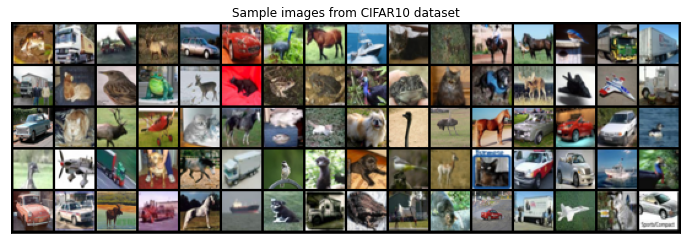

In [12]:
tmp_dl = DataLoader(
    torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transforms.ToTensor()
    ),
    batch_size=16 * 5,
)
images, labels = next(iter(tmp_dl))

fig, ax = plt.subplots(figsize=(12, 6))
plt.title("Sample images from CIFAR10 dataset")
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
plt.show()

In [15]:
def accuracy (net, loader):
    correct = 0
    total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(torch.device('cpu')), targets.to(torch.device('cpu'))
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct/total

In [17]:
print("Training set accuracy: " + str(accuracy(model, train_loader)))
print("Test set accuracy: " + str(accuracy(model, test_loader)))

Training set accuracy: 0.8864
Test set accuracy: 0.887


In [18]:
forget_set, retain_set = torch.utils.data.random_split(training_set, [0.1, 0.9])
forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=128, shuffle=False, num_workers=2
)
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=128, shuffle=False, num_workers=2
)

In [27]:
def unlearning(net, retain, forget, validation):
    """Unlearning by fine-tuning.

    Fine-tuning is a very simple algorithm that trains using only
    the retain set.

    Args:
      net : nn.Module.
        pre-trained model to use as base of unlearning.
      retain : torch.utils.data.DataLoader.
        Dataset loader for access to the retain set. This is the subset
        of the training set that we don't want to forget.
      forget : torch.utils.data.DataLoader.
        Dataset loader for access to the forget set. This is the subset
        of the training set that we want to forget. This method doesn't
        make use of the forget set.
      validation : torch.utils.data.DataLoader.
        Dataset loader for access to the validation set. This method doesn't
        make use of the validation set.
    Returns:
      net : updated model
    """
    epochs = 5

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    net.train()

    for _ in range(epochs):
        for inputs, targets in retain:
            inputs, targets = inputs.to(torch.device('cpu')), targets.to(torch.device('cpu'))
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        scheduler.step()

    net.eval()
    return net

In [28]:
model_ft = resnet18(weights=None, num_classes=10)
model_ft.load_state_dict(weights_pretrained)

# Execute the unlearing routine. This might take a few minutes.
# If run on colab, be sure to be running it on  an instance with GPUs
model_ft = unlearning(model_ft, retain_loader, forget_loader, test_loader)

In [29]:
print(f"Retain set accuracy: {100.0 * accuracy(model_ft, retain_loader):0.1f}%%")
print(f"Test set accuracy: {100.0 * accuracy(model_ft, test_loader):0.1f}%%")

Retain set accuracy: 94.4%%
Test set accuracy: 92.7%%
